Faz o download do conjunto de dados de gatos e cachorros

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

Descompacta o arquivo baixado

In [ ]:
!unzip cats_and_dogs_filtered.zip

Remove o arquivo ZIP após a descompactação

In [ ]:
!rm -rf cats_and_dogs_filtered.zip

Importa as bibliotecas necessárias

In [2]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout
import tensorflow as tf

Carrega o modelo pré-treinado MobileNet com pesos da ImageNet, excluindo a camada superior (fully connected)

In [ ]:
model=MobileNet(weights='imagenet',include_top=False)

Define a saída do modelo MobileNet como entrada para uma camada de Global Average Pooling, que calcula a média global das features

In [4]:
x=model.output
x=GlobalAveragePooling2D()(x)

Adiciona camadas densas à arquitetura do modelo, culminando em uma camada de saída com ativação sigmoidal

In [5]:
x=Dense(50,activation='relu')(x)
preds=Dense(1,activation='sigmoid')(x)
model=Model(inputs=model.input,outputs=preds)

Define quais camadas do modelo serão treináveis e quais não serão

In [6]:
for layer in model.layers[:88]:
    layer.trainable=False
for layer in model.layers[88:]:
    layer.trainable=True

Define o tamanho do lote para treinamento

In [ ]:
batch_size = 32

Cria geradores de dados para treinamento e teste com transformações

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.4,
                                   zoom_range = 0.4,
                                   height_shift_range=0.3,
                                   width_shift_range=0.3,
                                   rotation_range=50,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

Carrega dados de treinamento e validação usando os geradores

In [ ]:
train = train_datagen.flow_from_directory('cats_and_dogs_filtered/train',
                                                 target_size = (224, 224),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary')

validation = test_datagen.flow_from_directory('cats_and_dogs_filtered/validation',
                                            target_size = (224, 224),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Compila o modelo, definindo otimizador, função de perda e métricas para avaliação

In [7]:
model.compile(optimizer=Adam(learning_rate = 0.0001),loss='binary_crossentropy',metrics=['accuracy'])

Treina o modelo usando os geradores de dados definidos anteriormente

In [ ]:
history = model.fit_generator(generator = train,
                              steps_per_epoch = 2000/batch_size,
                              epochs = 20,
                              validation_data = validation,
                              validation_steps = 1000/batch_size)

Salva os pesos do treinamento

In [ ]:
model.save('cats_and_dogs.keras')

Carrega e prepara uma imagem de teste

In [ ]:
test_image = tf.keras.utils.load_img('cao.jpg', target_size = (224, 224))

test_image = tf.keras.utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
test_image = test_image/255

Realiza a predição da classe da imagem usando o modelo treinado, verifica o resultado da predição e imprime se é um cachorro ou um gato

1/1 [==============================] - 1s 568ms/step
dog


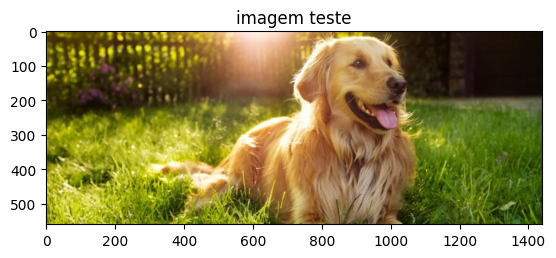

In [ ]:
result = model.predict(test_image)

if result[0][0] > 0.5:
    prediction = 'dog'
else:
    prediction = 'cat'

print(prediction)

#plotar
img = mpimg.imread('cao.jpg')
imgplot = plt.imshow(img)
plt.title('imagem teste')
plt.show()